In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)

# Table of contents
1. [Normal Model](#introduction)
2. [Custom Model I](#model1)
3. [Custom Model II](#model2)

In [2]:
np.random.seed(7)

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Normal Model <a name="introduction"></a>
* Convelutional Layer w/ RELU activation
* Flattening Layer
* Dense Layer 1 w/ RELU activation
* Dense Layer 2 w/ Linear activation

In [5]:
class ModelOne(Model):
    def __init__(self):
        super(ModelOne, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model=ModelOne()

In [6]:
# It uses crossentropy between the labels and predictions to compute loss.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [7]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [8]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [9]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [10]:
EPOCHS = 5

In [11]:
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_acc.result() * 100)
    test_loss_results.append(test_loss.result())
    test_accuracy_results.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.13774406909942627, Accuracy: 95.8133316040039, Test Loss: 0.0634661316871643, Test Accuracy: 97.82999420166016
Epoch 2, Loss: 0.043882232159376144, Accuracy: 98.62999725341797, Test Loss: 0.0512298122048378, Test Accuracy: 98.06999969482422
Epoch 3, Loss: 0.02151428908109665, Accuracy: 99.28500366210938, Test Loss: 0.05104970559477806, Test Accuracy: 98.21333312988281
Epoch 4, Loss: 0.013450423255562782, Accuracy: 99.51499938964844, Test Loss: 0.058222975581884384, Test Accuracy: 98.272

In [12]:
model.summary()

Model: "model_one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2769024   
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


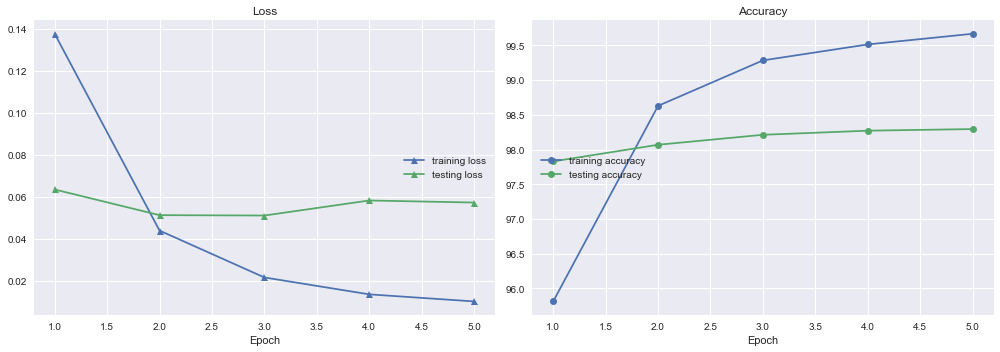

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=6)
fig.tight_layout()

# Custom Model I <a name="model1"></a>
* Convelutional Layer w/ RELU activation
* Flattening Layer
* Dense Layer w/ Linear activation

In [14]:
class ModelTwo(Model):
    def __init__(self):
        super(ModelTwo, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        return self.d2(x)

model=ModelTwo()

In [15]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [16]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [17]:
train_loss_results.clear()
train_accuracy_results.clear()
test_loss_results.clear()
test_accuracy_results.clear()


for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_acc.result() * 100)
    test_loss_results.append(test_loss.result())
    test_accuracy_results.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.13062112033367157, Accuracy: 96.1500015258789, Test Loss: 0.07205516844987869, Test Accuracy: 98.19999694824219
Epoch 2, Loss: 0.054893337190151215, Accuracy: 98.39166259765625, Test Loss: 0.06225225701928139, Test Accuracy: 98.17713928222656
Epoch 3, Loss: 0.03830333426594734, Accuracy: 98.8550033569336, Test Loss: 0.057482581585645676, Test Accuracy: 98.1624984741211
Epoch 4, Loss: 0.026677165180444717, Accuracy: 99.1866683959961, Test Loss: 0.06702659279108047, Test Accuracy: 98.1511

In [18]:
model.summary()

Model: "model_two"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  320       
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


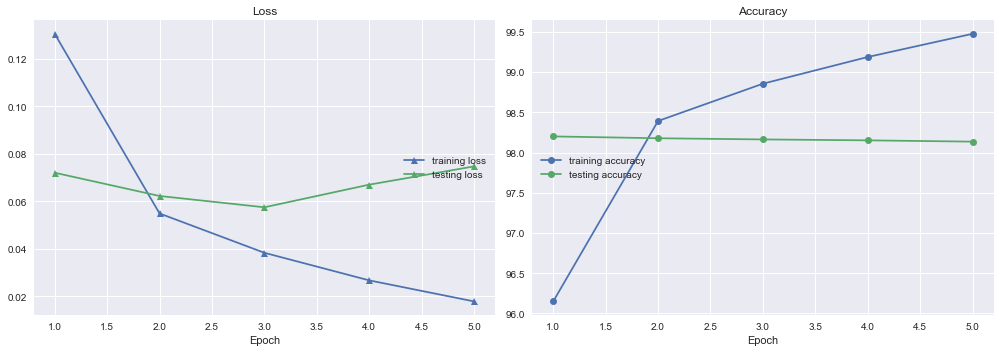

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=6)
fig.tight_layout()

# Custom Model II  <a name="model2"></a>
* Convelutional Layer w/ Linear Activation
* Flattening Layer
* Dense Layer 1 w/ Linear activation
* Dense Layer 2 w/ Linear activation

In [20]:
class ModelThree(Model):
    def __init__(self):
        super(ModelThree, self).__init__()
        self.conv1 = Conv2D(32, 3)
        self.flatten = Flatten()
        self.d1 = Dense(128)
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model=ModelThree()

In [21]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [22]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [23]:
train_loss_results.clear()
train_accuracy_results.clear()
test_loss_results.clear()
test_accuracy_results.clear()

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_acc.result() * 100)
    test_loss_results.append(test_loss.result())
    test_accuracy_results.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.38727256655693054, Accuracy: 89.52666473388672, Test Loss: 0.30440202355384827, Test Accuracy: 97.50454711914062
Epoch 2, Loss: 0.30687248706817627, Accuracy: 91.36833190917969, Test Loss: 0.31383466720581055, Test Accuracy: 97.01083374023438
Epoch 3, Loss: 0.2971585988998413, Accuracy: 91.68333435058594, Test Loss: 0.2920108735561371, Test Accuracy: 96.62000274658203
Epoch 4, Loss: 0.288866251707077, Accuracy: 91.83999633789062, Test Loss: 0.30312058329582214, Test Accuracy: 96.2600021

In [24]:
model.summary()

Model: "model_three"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  2769024   
_________________________________________________________________
dense_4 (Dense)              multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


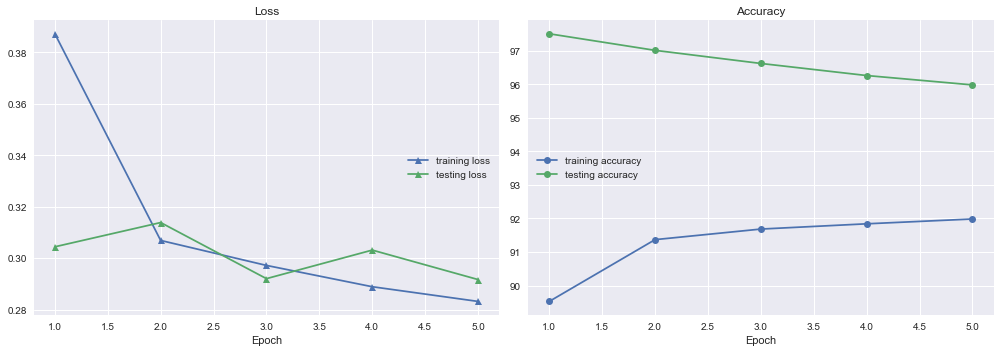

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=6)
fig.tight_layout()